**Processing Files**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls

guttenberg2.txt  guttenberg-ch1.txt  guttenberg-fr-ch1.txt  sample_data/


In [ ]:
with open('guttenberg2.txt', 'r', encoding='utf-8') as filedesc:
  text = filedesc.read()
text[:30], len(text)

('Chapter 1\n\n\nHappy families are', 1966150)

In [ ]:
c_text = text.lower().replace("\n", " ")
for chr in ",.:;?!$()/_&%*@'`":
  c_text = c_text.replace(f'{chr}', f' {chr} ')
c_text[:30], len(c_text)

('chapter 1   happy families are', 2095240)

In [ ]:
import re
with open('guttenberg2.txt', 'r', encoding='utf-8') as filedesc:
  text = filedesc.read()
text_processing = re.split(r'([,.:;?_!"()\']|--|\s)', text)
text_processing[:10], len(text_processing)

(['Chapter', ' ', '1', '\n', '', '\n', '', '\n', 'Happy', ' '], 876633)

In [ ]:
text_processing = [i.strip() for i in text_processing if i.strip()]
text_processing[:7]

['Chapter', '1', 'Happy', 'families', 'are', 'all', 'alike']

In [ ]:
allwords = sorted(set(text_processing))
vocabulary_size = len(allwords)
vocabulary = {word_: integer_ for integer_, word_ in enumerate(allwords)}
vocabulary_size,

(14167,)

In [ ]:
for key, item in enumerate(vocabulary.items()):
  print(item, end =' ')
  if key >=50: break

('!', 0) ('"', 1) ("'", 2) ('(', 3) (')', 4) (',', 5) ('--', 6) ('-`', 7) ('.', 8) ('015', 9) ('038', 10) ('1', 11) ('10', 12) ('11', 13) ('12', 14) ('13', 15) ('14', 16) ('15', 17) ('16', 18) ('17', 19) ('17th', 20) ('18', 21) ('1863', 22) ('1864', 23) ('19', 24) ('2', 25) ('20', 26) ('21', 27) ('22', 28) ('23', 29) ('24', 30) ('25', 31) ('26', 32) ('27', 33) ('28', 34) ('29', 35) ('2nd', 36) ('3', 37) ('30', 38) ('30th', 39) ('31', 40) ('32', 41) ('33', 42) ('34', 43) ('35', 44) ('36', 45) ('4', 46) ('5', 47) ('6', 48) ('7', 49) ('8', 50) 

**Tokenization**

In [ ]:
allwords = sorted(list(set(text_processing)))
allwords.extend(["<|END|>", '<|unk|>'])
vocabulary = {word_: integer_ for integer_, word_ in enumerate(allwords)}
list(vocabulary.items())[100:104]

[('Alphonse', 100), ('Already', 101), ('Although', 102), ('Altogether', 103)]

In [ ]:
class Tokenizer:
  def __init__(self, vocabulary):
    self.str_to_int = vocabulary
    self.int_to_str = {int_: str_ for str_, int_ in vocabulary.items()}
  def encode(self, text):
    text_pre = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    text_pre = [item.strip() for item in text_pre if item.strip() ]
    text_pre = [item if item in self.str_to_int else '<|unk|>' for item in text_pre]
    ids = [self.str_to_int[str_] for str_ in text_pre]
    return ids
  def decode(self, ids):
    text = ' '.join([self.int_to_str[i] for i in ids])
    text = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    return text

In [ ]:
tokenizer = Tokenizer(vocabulary)
ids = tokenizer.encode(text)
tokenizer.decode(ids)[:10]

['Chapter', ' ', '1', ' ', 'Happy', ' ', 'families', ' ', 'are', ' ']

In [ ]:
from importlib.metadata import version
import tiktoken

In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')

In [ ]:
text_g = ('''
The Project Gutenberg eBook <|endoftext|> of Anna Karenina, by Leo Tolstoy

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.''')
ints = tokenizer.encode(text_g, allowed_special={"<|endoftext|>"})
strings = tokenizer.decode(ints)
len(ints), ints, strings

(8,
 [198, 464, 4935, 20336, 46566, 220, 50256, 764],
 '\nThe Project Gutenberg eBook <|endoftext|> .')

In [ ]:
encoded_text = tokenizer.encode(text_g, allowed_special={"<|endoftext|>"})
encoded_sample = encoded_text[50:]

**Sample batches**

In [ ]:
context_size = 4
x = encoded_sample[: context_size]
y = encoded_sample[1: context_size]
x, y

([8203, 4548, 9196, 12762], [4548, 9196, 12762])

In [ ]:
for i in range(1, context_size +1):
  print(encoded_sample[:i], ' --- ', encoded_sample[i])

for i in range(1, context_size +1):
  print(tokenizer.decode(encoded_sample[:i]), ' --- ',
          tokenizer.decode([encoded_sample[i]]))

[8203]  ---  4548
[8203, 4548]  ---  9196
[8203, 4548, 9196]  ---  12762
[8203, 4548, 9196, 12762]  ---  12607
['little']  ---  ['decanters']
['little', ' ', 'decanters']  ---  ['on']
['little', ' ', 'decanters', ' ', 'on']  ---  ['the']
['little', ' ', 'decanters', ' ', 'on', ' ', 'the']  ---  ['table']


**Dataset and DataLoader**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class Dataset_v1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(txt)

    for i in range(0, len(token_ids) -max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i+1:i + max_length +1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

In [ ]:
dataset = Dataset_v1(text, tokenizer, max_length=256, stride=128)
batch_size = 4
dataloader = DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True,
    num_workers = 0
)

In [ ]:
def DataLoader_v1(txt, batch_size = 4,
                  max_length = 256, stride = 128,
                  shuffle = True, drop_last = True, num_workers = 0):
  tokenizer = tiktoken.get_encoding('gpt2')
  dataset = Dataset_v1(text, tokenizer, max_length, stride)
  dataloader = DataLoader(dataset,
    batch_size = batch_size, shuffle = True, drop_last = True, num_workers = 0)
  return dataloader

In [ ]:
''' recap each step from the preprocessing '''
with open('guttenberg2.txt', 'r', encoding='utf-8') as filedesc:
  new_text = filedesc.read()

dataloader = DataLoader_v1(new_text, batch_size=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
next(data_iter)

[tensor([[ 1046,    72, 13557,  ...,    13,   198,   198],
         [21000, 18657,  2007,  ...,    13,   198,   198],
         [12659,  1290,    12,  ...,   262,  5156,   338],
         [  284,   307,   826,  ...,  5779,    11,  3763]]),
 tensor([[   72, 13557,  1318,  ...,   198,   198,     1],
         [18657,  2007,   750,  ...,   198,   198,     1],
         [ 1290,    12,  8272,  ...,  5156,   338,   736],
         [  307,   826,    11,  ...,    11,  3763,     0]])]

In [ ]:
input_, target_ = next(data_iter)
input_, target_

(tensor([[ 6830,   373, 11069,  ...,   507,    11,   996],
         [  262,   649,  4039,  ...,  5012,   272,  9128],
         [  503,   257,  8011,  ...,  3612,    11,   290],
         [  619,    82,   198,  ...,  2993,   523, 42075]]),
 tensor([[  373, 11069,   284,  ...,    11,   996,  3360],
         [  649,  4039,  1244,  ...,   272,  9128,  4597],
         [  257,  8011,    11,  ...,    11,   290,   339],
         [   82,   198,   392,  ...,   523, 42075,   284]]))

**Embedding**

In [ ]:
'''
Convert text into numerical vectors, embeddings, transform discrete data,
text -images = more into vector spaces, process text into tokesn with tokenizer
class, enhance the model's understanding
BPE tokenizer used in GPT-3 efficiently handles this by breaking down words
into individual characters
Use sliding window on tokenized data to generate input-target pairs
Embedding layer in Pytorch is lookup operation given the token
While token embeddings provide consistent vector representations to capture
meaning and semantics we need the positioning (positional embedding) and add it
tothe token embedding which is optimized during training
'''

In [ ]:
torch.manual_seed(32)
output_dim = 256
embedding_ = torch.nn.Embedding(vocabulary_size, output_dim)
embedding_.weight

Parameter containing:
tensor([[-1.7416, -0.3635,  0.9803,  ...,  0.5644, -0.8004,  1.5482],
        [-1.1733, -0.3457, -0.6575,  ...,  0.9468,  0.8291,  0.6873],
        [ 0.5252,  0.4847, -0.2217,  ..., -2.1106,  0.2912, -0.4572],
        ...,
        [ 0.4858, -0.7001,  0.4734,  ..., -0.8532, -2.0940,  0.6317],
        [ 1.4763, -0.7158,  3.0351,  ..., -0.9276,  1.3366,  1.1988],
        [-0.3399,  0.6682, -1.5056,  ..., -0.9517,  0.3251,  0.4580]],
       requires_grad=True)

In [ ]:
embedding_(torch.tensor([4]))

In [ ]:
embedding_, input_.shape

(Embedding(14167, 256), torch.Size([4, 256]))

In [ ]:
with open('guttenberg2.txt', 'r', encoding='utf-8') as filedesc:
  new_text = filedesc.read()

dataloader = DataLoader_v1(
    new_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
batch_1 = next(data_iter)
batch_2 =  next(data_iter)

In [ ]:
input_, target_ = batch_1
input_, target_

(tensor([[ 2342,   319,   644,   198],
         [ 1169, 38265,   293,    11],
         [   11,   290,  6150,   284],
         [  351, 34730,   290, 47886],
         [  284,   607,    13,  1375],
         [  345,   644,   345,  3551],
         [  198,    67,   570,  1431],
         [  477,   286,   606,   547]]),
 tensor([[  319,   644,   198,   258],
         [38265,   293,    11,  3538],
         [  290,  6150,   284, 15849],
         [34730,   290, 47886,  2951],
         [  607,    13,  1375,  2497],
         [  644,   345,  3551,   546],
         [   67,   570,  1431,   355],
         [  286,   606,   547,  1035]]))

In [ ]:
torch.manual_seed(132)
output_dim = 256
vocab_size = 50257
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
embedding_layer

Embedding(50257, 256)

In [ ]:
token_embedding_layer = embedding_layer(input_)
token_embedding_layer.shape

torch.Size([8, 4, 256])

In [ ]:
context_length = max_length = 4
positional_embedding_layer = torch.nn.Embedding(context_length, output_dim)
positional_embedding_layer = embedding_layer(torch.arange(context_length))
positional_embedding_layer.shape

torch.Size([4, 256])

In [ ]:
input_embedding = token_embedding_layer + positional_embedding_layer
input_embedding.shape

torch.Size([8, 4, 256])

**Attention Mechanism**

In [ ]:
'''
Basic self-attention framework in neural networks, causal attention module that
allows models to generate one token at a time, and masking randomly selected
attention weights with dropout to reduce overfitting
Stacking multiple causal attention modules into multi-head attention
'''

In [ ]:
''' simplified version '''
input = input_a.shape,

(torch.Size([6, 3]), torch.Size([6, 3]))

In [ ]:
query = input[1]
attention_score = torch.empty(input.shape[0])
for i, x_i in enumerate(input):
  attention_score[i] = torch.dot(x_i, query)
attention_score

In [ ]:
''' attention scores as a dot product of inputs '''
dotProduct =  torch.dot(input[0], query)
dotProduct

In [ ]:
''' attention weights the normalized version of attention scores '''
attention_weights_tmp = attention_score/attention_score.sum()
attention_weights_tmp

In [ ]:
def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum(dim=0)
attention_weights_naive = softmax_naive(attention_score)
attention_weights_naive

In [ ]:
''' context vectors as weighted sum over inputs '''
query = input[1]
attention_weights = torch.softmax(attention_score, dim=0)
context_vector = torch.zeros(query.shape)
for i, x_i in enumerate(input):
  context_vector += attention_score[i] *x_i
context_vector, attention_weights, attention_weights.sum()

Generalize these steps

In [ ]:
attn_scores = torch.empty(6, 6)
for i,x_i in enumerate(input):
  for j,x_j in enumerate(input):
    attn_scores[i,j] = torch.dot(x_i, x_j)
attn_scores

In [ ]:
attn_scores_2 = input @input.T
attn_scores_2 == attn_scores

In [ ]:
attention_weights = torch.softmax(attn_scores, dim=-1)
all_context_vectors = attention_weights @ input
all_context_vectors

In [ ]:
''' self-attention with trainable weights '''
x_2 = input[1]
dim_in_emb = input.shape[1]
dim_out_emb = 2
torch.manual_seed(123)

W_query = torch.nn.Parameter(
    torch.rand(dim_in_emb, dim_out_emb, requires_grad=False))
W_key = torch.nn.Parameter(
    torch.rand(dim_in_emb, dim_out_emb, requires_grad=False))
W_value = torch.nn.Parameter(
    torch.rand(dim_in_emb, dim_out_emb, requires_grad=False))

query_2 = x_2 @ W_query
keys_2 = x_2 @ W_key
values_2 = x_2 @ W_value

keys = input @W_key
values = input @ W_value

attention_score_2 = query_2 @ keys.T

d_k = keys.shape[-1]
attention_weights_2 = torch.softmax(attention_score_2/d_k**0.5, dim=-1)

contenxt_vectors_2 = attention_weights_2 @ values

In [ ]:
query_2, keys_2, values_2, keys.shape, values.shape, \
attention_score_2, attention_weights_2, contenxt_vectors_2

In [ ]:
''' wrap all this functionality in the self-attention class '''
import torch.nn as nn

class SelfAttention_v1(nn.Module):
  def __init__(self, dim_in_emb, dim_out_emb):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(dim_in_emb, dim_out_emb))
    self.W_key = nn.Parameter(torch.rand(dim_in_emb, dim_out_emb))
    self.W_value = nn.Parameter(torch.rand(dim_in_emb, dim_out_emb))

  def forward(self, x):
    queries = x @ self.W_query
    keys = x @ self.W_key
    values = x @ self.W_value
    attn_score = queries @ keys.T
    attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
    contenxt_vectors = attn_weights @ values
    return contenxt_vectors

torch.manual_seed(132)
self_attn = SelfAttention_v1(dim_in_emb, dim_out_emb)
self_attn(input)

In [ ]:
class SelfAttention_v2(nn.Module):
  def __init__(self, dim_in_emb, dim_out_emb, qkv_bias=False):
    super().__init__()
    self.W_query = nn.Linear(torch.rand(dim_in_emb, dim_out_emb, bias=qkv_bias))
    self.W_key = nn.Linear(torch.rand(dim_in_emb, dim_out_emb, bias=qkv_bias))
    self.W_value = nn.Linear(torch.rand(dim_in_emb, dim_out_emb, bias=qkv_bias))

  def forward(self, x):
    queries = x @ W_query
    keys = x @ W_key
    values = x @ W_value
    attn_score = queries @ keys.T
    attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
    contenxt_vectors = attn_weights @ values
    return contenxt_vectors

torch.manual_seed(132)
self_attn = SelfAttention_v2(dim_in_emb, dim_out_emb)
self_attn(input)

In [ ]:
class CausalAttention_v1(nn.Module):
  def __init__(self, dim_in_emb, dim_out_emb,
               context_length, dropout, qkv_bias=False):
    super().__init__()
    self.W_query = nn.Linear(dim_in_emb, dim_out_emb, bias=qkv_bias)
    self.W_key = nn.Linear(dim_in_emb, dim_out_emb, bias=qkv_bias)
    self.W_value = nn.Linear(dim_in_emb, dim_out_emb, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(
            context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, dim_in_emb = x.shape
    queries = x @ W_query
    keys = x @ W_key
    values = x @ W_value

    attn_score = queries @ keys.transpose(1,2)
    attn_score.masked_fill_(
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
    contenxt_vectors = attn_weights @ values
    return contenxt_vectors

torch.manual_seed(132)
batch = torch.stack((input, input), dim=0)
context_length = batch.shape[1]
ca_attn = CausalAttention_v1(dim_in_emb, dim_out_emb, context_length, 0.0)
context_vectors = ca_attn(batch)
context_vectors

In [ ]:
''' Multi-head attention layer '''
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_in_emb, dim_out_emb, context_length,
               dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.heads = nn.ModuleList(
        [CausalAttention_v1(
          dim_in_emb, dim_out_emb, context_length, dropout, qkv_bias)
        for _ in range(num_heads)]
    )

  def forward(self, x):
    return torch.cat([head(x) for head in self.heads], dim=-1)

torch.manual_seed(132)
context_length = batch.shape[1]
dim_in_emb, dim_out_emb = 3, 2
mha_ = MultiHeadAttention(
    dim_in_emb, dim_out_emb, context_length, 0.0, num_heads=2)
context_vectors = mha_(batch)
context_vectors.shape, #context_vectors

In [ ]:
''' Multi-head attention with weights split '''

In [ ]:
class MultiHeadAttention_opt(nn.Module):
  def __init__(self, dim_in_emb, dim_out_emb, context_length, dropout, num_heads,
               qkv_bias=False):
    super().__init__()

    self.dim_out_emb = dim_out_emb
    self.num_heads = num_heads
    self.head_dim = dim_out_emb // num_heads

    self.W_query = nn.Linear(dim_in_emb, dim_out_emb, bias=qkv_bias)
    self.W_key = nn.Linear(dim_in_emb, dim_out_emb, bias=qkv_bias)
    self.W_value = nn.Linear(dim_in_emb, dim_out_emb, bias=qkv_bias)
    self.out_proj = nn.Linear(dim_out_emb, dim_out_emb)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, dim_in_emb = x.shape

    queries = self.W_query(x)
    keys = self.W_key(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = keys.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)
    queries = queries.transpose(1, 2)

    attn_score = queries @ keys.transpose(2, 3)

    attn_score.masked_fill_(
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

    attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vectors = (attn_weights @ values).transpose(1, 2)
    context_vectors = context_vectors.contiguous().view(
                                              b, num_tokens, self.dim_out_emb)
    context_vectors = self.out_proj(context_vectors)
    return context_vectors

In [ ]:
torch.manual_seed(132)
batch_size, context_length, dim_in_emb = batch.shape #([2, 6, 3])
dim_out_emb = 2
mha_optimized = MultiHeadAttention_opt(
    dim_in_emb, dim_out_emb, context_length, 0.0, num_heads=2)
context_vectors = mha_optimized(batch)
context_vectors.shape, #context_vectors

(torch.Size([2, 6, 2, 1]),)

**Transformer Architecture**

In [ ]:
''' Transformer architecture
1 -Layer normalization to ensure each layer's output have consistent mean/var
during training 2. - Shortcut connections to skip one or more layers feeding
the output of one layer directly to mitigate vanishing gradients during training
3. Transformer blocks combining masked multi-head modules and fully connected
FF networks using GELU - 4. Configuration for the GPT model parameters
5. - The text generation capability of GPT to decode output tensors into text by
sequentially predicting a token one at a time based on given input/context
'''

In [ ]:
import torch
import torch.nn as nn

In [ ]:
Config = {
    'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768,
    'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
  def forward(self, x):
    return x

class LayerNormalization(nn.Module):
  def __init__(self,cfg):
    super().__init__()
  def forward(self, x):
    return x

class Model(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.token_embedding_layer = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_embedding_layer = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_embedding = nn.Dropout(cfg['drop_rate'])
    self.transformer_blocks = nn.Sequential(
        *(TransformerBlock(cfg) for _ in range(cfg['n_layers'])))
    self.final_normalization = LayerNormalization(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tokens_embedding = self.token_embedding_layer(in_idx)
    positional_embeddings = self.pos_embedding_layer(
        torch.arange(seq_len, device=in_idx.device))
    x = tokens_embedding + positional_embeddings
    x = self.drop_embedding(x)
    x = self.transformer_blocks(x)
    x = self.final_normalization(x)
    logits = self.out_head(x)
    return logits

In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
text_1 = 'The Project Gutenberg eBook of Anna Karenina by Leo Tolstoy'
text_2 = 'License included with this eBook or online www.gutenberg.org'
batch.append(torch.tensor(tokenizer.encode(text_1)))
batch.append(torch.tensor(tokenizer.encode(text_2)))
batch = torch.stack(batch, dim=0)
len(batch[0]), len(batch[1])

(13, 13)

In [ ]:
model = Model(Config)
model

Model(
  (token_embedding_layer): Embedding(50257, 768)
  (pos_embedding_layer): Embedding(1024, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock()
    (1): TransformerBlock()
    (2): TransformerBlock()
    (3): TransformerBlock()
    (4): TransformerBlock()
    (5): TransformerBlock()
    (6): TransformerBlock()
    (7): TransformerBlock()
    (8): TransformerBlock()
    (9): TransformerBlock()
    (10): TransformerBlock()
    (11): TransformerBlock()
  )
  (final_normalization): LayerNormalization()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
logits = model(batch)
logits.shape, #logits

(torch.Size([2, 13, 50257]),)

In [ ]:
''' normalizing activations w/ layer normalization'''
# generate the data
batch_ = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_)
mean, var = out.mean(dim=-1, keepdim=True), out.var(dim=-1, keepdim=True)
out, mean, var

(tensor([[0.2436, 0.9998, 0.0000, 1.3965, 0.0000, 0.0000],
         [0.5880, 0.0000, 0.0578, 0.0000, 0.0000, 0.0000]],
        grad_fn=<ReluBackward0>),
 tensor([[0.4400],
         [0.1076]], grad_fn=<MeanBackward1>),
 tensor([[0.3695],
         [0.0559]], grad_fn=<VarBackward0>))

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
out_norm

tensor([[-0.3230,  0.9209, -0.7238,  1.5735, -0.7238, -0.7238],
        [ 2.0315, -0.4552, -0.2108, -0.4552, -0.4552, -0.4552]],
       grad_fn=<DivBackward0>)

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x -mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

layer_norm = LayerNormalization(emb_dim=5)
out_layer_norm = layer_norm(batch_)
mean = out_layer_norm.mean(dim=-1, keepdim=True)
var = out_layer_norm.var(dim=-1, keepdim=True, unbiased=False)
out_layer_norm, mean, var

(tensor([[-1.1374, -0.4933,  1.8258,  0.1372, -0.3324],
         [ 0.6198,  1.0866, -0.3940,  0.4435, -1.7559]], grad_fn=<AddBackward0>),
 tensor([[0.0000e+00],
         [5.9605e-09]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))

**Implementing FeedForward with GeLU activations**

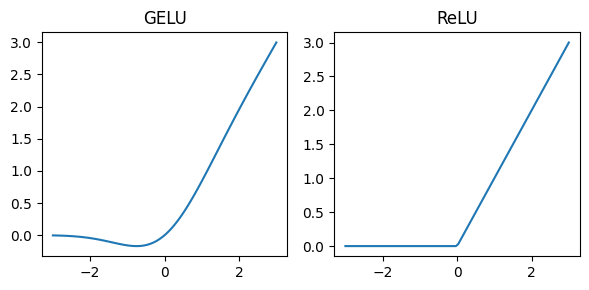

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5* x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.0447716 * torch.pow(x,3))
    ))

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)

import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), 1):
  plt.subplot(1, 2, i)
  plt.plot(x,y)
  plt.title(f'{label}')
plt.tight_layout()
plt.show()

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']),
    )

  def forward(self,x):
    return self.layers(x)

ff = FeedForward(Config)
x = torch.rand(2, 3, 768)
out = ff(x)
out.shape, Config['emb_dim'], #out,

(torch.Size([2, 3, 768]), 768)

Deep Neural Networks

In [ ]:
''' Neural network with shortcut connections '''
class DeepNeuralNetowork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_out = layer(x)
      if self.use_shortcut and x.shape == layer_out.shape:
        x = x + layer_out
      else:
        x = layer_out
    return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
input = torch.tensor([1., 0., -1.])
torch.manual_seed(132)
mwsh = DeepNeuralNetowork(layer_sizes, use_shortcut=False)
def gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])
  loss = nn.MSELoss()
  loss = loss(output,target)
  loss.backward()
  for name, param in model.named_parameters():
    if 'weight':
      print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')
gradients(mwsh, input)

layers.0.0.weight has gradient mean of 4.9807589675765485e-05
layers.0.0.bias has gradient mean of 7.471138815162703e-05
layers.1.0.weight has gradient mean of 0.00011093103239545599
layers.1.0.bias has gradient mean of 0.0008753305301070213
layers.2.0.weight has gradient mean of 0.0006009326316416264
layers.2.0.bias has gradient mean of 0.004141479264944792
layers.3.0.weight has gradient mean of 0.001894055982120335
layers.3.0.bias has gradient mean of 0.013888943009078503
layers.4.0.weight has gradient mean of 0.008871190249919891
layers.4.0.bias has gradient mean of 0.051304250955581665


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
mwsh = DeepNeuralNetowork(layer_sizes, use_shortcut=True)
gradients(mwsh, input)

layers.0.0.weight has gradient mean of 0.003889854997396469
layers.0.0.bias has gradient mean of 0.005834782496094704
layers.1.0.weight has gradient mean of 0.003715590573847294
layers.1.0.bias has gradient mean of 0.005611700937151909
layers.2.0.weight has gradient mean of 0.009199644438922405
layers.2.0.bias has gradient mean of 0.013666793704032898
layers.3.0.weight has gradient mean of 0.005073778331279755
layers.3.0.bias has gradient mean of 0.009616758674383163
layers.4.0.weight has gradient mean of 0.038982097059488297
layers.4.0.bias has gradient mean of 0.052308082580566406


Attention and linear layers in  transformer block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention_opt(
        dim_in_emb = cfg['emb_dim'],
        dim_out_emb = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        dropout = cfg['drop_rate'],
        qkv_bias = cfg['qkv_bias'])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNormalization(cfg['emb_dim'])
    self.norm2 = LayerNormalization(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.attention(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

x = torch.rand(2, 4, 768)
trnf_block = TransformerBlock(Config)
out = trnf_block(x)


In [ ]:
class GPT(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.positional_embedding = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_embedding = nn.Dropout(cfg['drop_rate'])
    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_normalization = LayerNormalization(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    token_embedding = self.token_embedding(in_idx)
    positional_embedding = self.positional_embedding(
        torch.arange(seq_len, device=in_idx.device) )
    x = token_embedding + positional_embedding
    x = self.drop_embedding(x)
    x = self.transformer_blocks(x)
    x = self.final_normalization(x)
    logits = self.out_head(x)
    return logits

In [ ]:
model_gpt = GPT(Config)

In [ ]:
out = model(batch)
out.shape, out

(torch.Size([2, 13, 50257]),
 tensor([[[ 0.9998, -0.6334, -0.2243,  ..., -0.7347, -0.0905, -0.2656],
          [-0.4434,  0.1494, -0.9669,  ..., -0.6166, -0.6777,  1.6482],
          [-0.0440,  0.6219,  0.7871,  ..., -0.0170, -0.3031,  0.4117],
          ...,
          [ 0.7793,  0.0108,  0.9134,  ...,  1.5485, -0.0767, -0.1357],
          [ 0.5521,  2.1198, -0.0658,  ..., -1.6713, -0.0582,  0.6999],
          [-1.0729,  0.3633, -1.2405,  ...,  0.8049,  0.0288,  0.4847]],
 
         [[ 1.1473, -0.9356,  0.2056,  ..., -0.8087, -0.6197,  0.2240],
          [ 0.4987,  0.4062, -0.2237,  ...,  0.2348,  1.5309,  0.6760],
          [ 0.2612,  0.0294,  1.6646,  ..., -1.1115, -1.2451, -0.5173],
          ...,
          [ 0.6197, -0.0715,  1.1852,  ...,  0.4778, -0.4336,  0.1047],
          [ 0.1189, -0.4237,  0.4810,  ..., -0.1871,  1.0509,  0.7817],
          [-0.3464,  0.4167, -0.9144,  ...,  1.0888, -0.0550,  0.7064]]],
        grad_fn=<UnsafeViewBackward0>))

In [ ]:
model_gpt.parameters()
total_params = sum([param.numel() for param in model_gpt.parameters()])
total_size = total_params*4/(1024*1024)
total_params, total_size

(163009536, 621.83203125)

In [ ]:
model_gpt.token_embedding.weight.shape, model_gpt.out_head.weight.shape

(torch.Size([50257, 768]), torch.Size([50257, 768]))

Text generation

In [ ]:
def generate_text(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_c = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_c)
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [ ]:
encoded = tokenizer.encode('this is just some text')
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
encoded_tensor.shape, encoded[:5]

(torch.Size([1, 5]), [5661, 318, 655, 617, 2420])

In [ ]:
model.eval()
text_out = generate_text(
    model=model_gpt,
    idx = encoded_tensor,
    max_new_tokens = 10,
    context_size = Config['context_length'])
text_out

tensor([[ 5661,   318,   655,   617,  2420, 18144,  8080, 17516, 39620, 33128,
          3731, 45370, 29908, 37743, 41087]])

In [ ]:
''' without training the model generates incoherent text  '''
decoded_text_out = tokenizer.decode(text_out.squeeze(0).tolist())
decoded_text_out

'this is just some textamera sustain volcanographed Abbey slight embodies wrapper humiliating Cheap'

In [ ]:
def text_to_tokenids(text, tokenizer):
  encoded = tokenizer.encode(text) #, allowed_special='<|endoftext|>')
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def tokenids_to_text(tokenids, tokenizer):
  return tokenizer.decode(tokenids.squeeze(0).tolist())

In [ ]:
file_path = 'ebook.txt'
#url = 'https://www.gutenberg.org/cache/epub/514/pg514.txt'
url = 'https://www.gutenberg.org/cache/epub/2600/pg2600.txt'
import os
import urllib.request
with urllib.request.urlopen(url) as response:
  text_ebook = response.read().decode('utf-8')
with open(file_path, 'w', encoding = 'utf-8') as fd:
  fd.write(text_ebook)

In [ ]:
with open('ebook.txt', 'r', encoding = 'utf-8') as fd:
  text_ebook = fd.read()

In [ ]:
with open('ebook2.txt', 'r', encoding = 'utf-8') as fd:
  text_ebook = fd.read()

In [ ]:
tokenized_ebooks = tokenizer.encode(text_ebook)

In [ ]:
len(tokenized_ebooks), len(text_ebook)

(286183, 1026358)

Training/validation

In [ ]:
train_split = 0.90
split_idx = int(train_split * len(text_ebook))
train_data = text_ebook[:split_idx]
val_data = text_ebook[split_idx:]

In [ ]:
train_dataset = Dataset_v1(
  train_data, tokenizer,
  max_length = Config['context_length'], stride= Config['context_length'])

batch_size = 4
train_loader = DataLoader(
  train_dataset, batch_size = batch_size, drop_last = True, shuffle = True,
)

In [ ]:
val_dataset = Dataset_v1(
  val_data, tokenizer,
  max_length = Config['context_length'], stride= Config['context_length'])

batch_size = 4
val_loader = DataLoader(
  val_dataset, batch_size = batch_size, drop_last = True, shuffle = True,
)

In [ ]:
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7dee5bf452d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dee5a2e04d0>)

In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([4, 1024]), torch.Size([4, 1024]))

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
  train_tokens += input_batch.numel()
val_tokens = 0
for input_batch, target_batch in val_loader:
  val_tokens += input_batch.numel()
train_tokens, val_tokens, train_tokens + val_tokens

(258048, 24576, 282624)

In [ ]:
def loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten() )
  return loss

In [ ]:
def loss_loader(data_loader, model, device, num_batches=None):
  tloss = 0
  if len(data_loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = loss_batch(input_batch, target_batch, model, device)
      tloss += loss.item()
    else:
      break
  # sums the loss for each batch, and averages the loss over allbatches
  return tloss/num_batches

Training

In [ ]:
model.train()

Model(
  (token_embedding_layer): Embedding(50257, 768)
  (pos_embedding_layer): Embedding(1024, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock()
    (1): TransformerBlock()
    (2): TransformerBlock()
    (3): TransformerBlock()
    (4): TransformerBlock()
    (5): TransformerBlock()
    (6): TransformerBlock()
    (7): TransformerBlock()
    (8): TransformerBlock()
    (9): TransformerBlock()
    (10): TransformerBlock()
    (11): TransformerBlock()
  )
  (final_normalization): LayerNormalization()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
with torch.no_grad():
  train_loss = loss_loader(train_loader, model, device)
  val_loss = loss_loader(val_loader, model, device)

train_loss, val_loss

(5.001023898049007, 5.628655751546224)

Training

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  with torch.no_grad():
    train_loss = loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [ ]:
def train_model(model, train_loader, val_loader, optimizer,device, num_epochs,
      eval_freq, eval_iter, tokenizer): #start_context
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step +=1

      if global_step % eval_freq ==0:
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f'epoch {epoch +1}, step {global_step}, train loss {train_loss:.3f}, val loss {val_loss:.3f}')

    #generate_and_print_sample(model, tokenizer, device,start_context)
  return

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.manual_seed(132)
optimizer = torch.optim.AdamW(
    model.parameters(), lr = 0.0004, weight_decay = 0.1 )
num_epochs = 10

train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
  eval_freq=15, eval_iter=1, tokenizer=tokenizer)

In [ ]:
def generate_content(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_embedding_layer.weight.shape[0]
  encoded = text_to_tokenids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text(model = model,
            idx=encoded, max_new_tokens = 50, context_size = context_size)
    decoded_text = tokenids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ''))
  model.train()

In [ ]:
model.to('cpu')
device = 'cpu'
model.eval()
start_context = "journey"
generate_content(model, tokenizer, device, start_context)

Temperature scaling

Top-k Sampling